# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [1]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')

--2021-03-20 14:25:39--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2021-03-20 14:25:40--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.2’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.01s   

2021-03-20 14:25:40 (6.66 MB/s) - 

In [2]:
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of constituency MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [3]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2021-03-20 14:25:42--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv.1’

mp_name_th_en.csv.1 100%[===================>] 316.80K  --.-KB/s    in 0.03s   

2021-03-20 14:25:42 (9.62 MB/s) - ‘mp_name_th_en.csv.1’ saved [324399/324399]



In [4]:
import csv
with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])

In [5]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## Task1: Preprocess dataset for Keras (1 point)
* 2 dictionaries for indexing (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding)

In [6]:
#FILL YOUR CODE HERE

#Preprocessing

#Input
input_chars = list(set(''.join(name_th)))
sorted_input_chars = sorted(input_chars)
sorted_input_chars.insert(0,'<PAD>') #PADDING for input

input_char_to_ix = { ch:i for i,ch in enumerate(sorted_input_chars) }
ix_to_input_char = { i:ch for i,ch in enumerate(sorted_input_chars) } #reverse dictionary

#output
output_chars = list(set(''.join(name_en)))
sorted_output_chars = sorted(output_chars)
sorted_output_chars.insert(0,'<PAD>') #PADDING for output
sorted_output_chars.append('</s>')

output_char_to_ix = { ch:i for i,ch in enumerate(sorted_output_chars) }
ix_to_output_char = { i:ch for i,ch in enumerate(sorted_output_chars) } #reverse dictionary

input_vocab_size = len(input_char_to_ix)
output_vocab_size = len(output_char_to_ix)

In [7]:
X = []
for line in name_th:
    temp=[]
    for char in line:
        temp.append(input_char_to_ix[char])
    X.append(temp)
Y = []
for line in name_en:
    temp=[]
    for char in line:
        temp.append(output_char_to_ix[char])
    temp.append(output_char_to_ix['</s>'])
    Y.append(temp)

data_size = len(name_th)

input_maxlen = len(max(name_th, key=len)) #max input length
output_maxlen = len(max(name_en, key=len)) #max input length
X = pad_sequences(X, maxlen=input_maxlen, padding='post')
X = to_categorical(X, input_vocab_size)
X = X.reshape(data_size, input_maxlen, input_vocab_size)

Y = pad_sequences(Y, maxlen=output_maxlen, padding='post')
Y = to_categorical(Y, output_vocab_size)
Y = Y.reshape(data_size, output_maxlen, output_vocab_size)

In [8]:
Y[0].shape

(19, 24)

# Attention Mechanism
## Task 2: Code your own (key-value) attention mechnism (1 point)
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo


In [9]:
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Lambda
def softMaxAxis1(x):
    return softmax(x,axis=1)

In [10]:
m = data_size
Tx = input_maxlen
Ty = output_maxlen

In [11]:
#These are global variables (shared layers)
## Fill your code here
## you are allowed to use code in the demo as your template.  

repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
splitter = Lambda(lambda x : tf.split(x, num_or_size_splits=2, axis=2))

#Attention function
fattn_1 = Dense(input_maxlen, activation = "tanh")
fattn_2 = Dense(1, activation = "relu")

activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)

In [12]:
def one_step_attention(a, s_prev):

    #Fill code here
    # Repeat the decoder hidden state to concat with encoder hidden states
    s_prev = repeator(s_prev)
    key, value = splitter(a)
    # print(a.shape)
    # print(key.shape)
    # print(value.shape)
    concat = concatenator([key,s_prev])

    # attention function
    e = fattn_1(concat)
    energies =fattn_2(e)
    # calculate attention_scores (softmax)
    attention_scores = activator(energies)
    #calculate a context vector
    context = dotor([attention_scores, value])
    
    return context  # return whatever you need to complete this homework 

## Task3: Create and train your encoder/decoder model here (1 point)
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [13]:
#FILL CODE HERE

n_h = 256 #hidden dimensions for encoder. This number can be adjusted freely, not related to dimensions for decoder, input, output
n_s = 256 #hidden dimensions for decoder. This number can be adjusted freely, not related to dimensions for encoder, input, output
encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(output_vocab_size, activation="softmax") #softmax output layer

In [14]:
#FIT YOUR MODEL HERE

def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()

    #Encoder Bi-LSTM
    # h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
    h = encoder_LSTM(X)

    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context = one_step_attention(h, s)
       
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
           
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

In [15]:
model = model(Tx, Ty, n_h, n_s, input_vocab_size, output_vocab_size)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 65)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 512)      659456      input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 256)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 [(None, 20, 256), (N 0           bidirectional[0][0]              
                                                                 bidirectional[0][0]          

In [17]:
opt = Adam(lr= 0.01, clipvalue=0.5)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [18]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Y.swapaxes(0,1))

In [31]:
model.fit([X, s0, c0], outputs, epochs=20)

Epoch 1/20
341/341 [==============================] - 131s 384ms/step - loss: 4.1642 - dense_2_loss: 0.0741 - dense_2_1_loss: 0.1613 - dense_2_2_loss: 0.2615 - dense_2_3_loss: 0.3700 - dense_2_4_loss: 0.4489 - dense_2_5_loss: 0.5005 - dense_2_6_loss: 0.5114 - dense_2_7_loss: 0.4881 - dense_2_8_loss: 0.4209 - dense_2_9_loss: 0.3297 - dense_2_10_loss: 0.2341 - dense_2_11_loss: 0.1546 - dense_2_12_loss: 0.0915 - dense_2_13_loss: 0.0545 - dense_2_14_loss: 0.0314 - dense_2_15_loss: 0.0149 - dense_2_16_loss: 0.0094 - dense_2_17_loss: 0.0056 - dense_2_18_loss: 0.0020 - dense_2_accuracy: 0.9831 - dense_2_1_accuracy: 0.9535 - dense_2_2_accuracy: 0.9256 - dense_2_3_accuracy: 0.8991 - dense_2_4_accuracy: 0.8713 - dense_2_5_accuracy: 0.8546 - dense_2_6_accuracy: 0.8491 - dense_2_7_accuracy: 0.8555 - dense_2_8_accuracy: 0.8743 - dense_2_9_accuracy: 0.9002 - dense_2_10_accuracy: 0.9290 - dense_2_11_accuracy: 0.9526 - dense_2_12_accuracy: 0.9725 - dense_2_13_accuracy: 0.9844 - dense_2_14_accuracy: 0.

In [32]:
model.save_weights('model_wt.h5')

# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! (1 point)
* Task 5: Show your visualization of attention scores on one of your example (1 point)

In [44]:
#task 4
#fill your code here

def prep_input(input_list):
    X = []
    for line in input_list:
        temp=[]
        for char in line:
            temp.append(input_char_to_ix[char])
        X.append(temp)
    X = pad_sequences(X, maxlen = input_maxlen, padding='post')
    X = to_categorical(X, input_vocab_size)
    X = X.reshape(len(input_list), input_maxlen, input_vocab_size)
    
    return X

EXAMPLES = ['ไกรสีห์', 'วิศรุต', 'งง', 'พีรพล', 'เทส', 'ทดสอบ', 'สมชาย']
s0_test = np.zeros((len(EXAMPLES), n_s))
c0_test = np.zeros((len(EXAMPLES), n_s))
EXAMPLES = prep_input(EXAMPLES)

prediction = model.predict([EXAMPLES , s0_test, c0_test])
prediction = np.swapaxes(prediction,0,1)
prediction = np.argmax(prediction, axis = -1)

for j in range(len(prediction)):
    print(prediction[j])
    output = ''.join([ix_to_output_char[int(i)] for i in prediction[j]])
    print(output)

[11 17  2 10 18 10 23  0  0  0  0  0  0  0  0  0  0  0  0]
kraisi</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
[21 10 18  2 17 20 19 23  0  0  0  0  0  0  0  0  0  0  0]
wisarut</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
[14  2 14 15 14  8 23  0  0  0  0  0  0  0  0  0  0  0  0]
nanong</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
[16  9 10 17  2 16  9 15 14 23  0  0  0  0  0  0  0  0  0]
phiraphon</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
[19  9  6 19 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
thet</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
[19 15 15 18 15 15 23  0  0  0  0  0  0  0  0  0  0  0  0]
toosoo</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
[18 15 13  4  9  2 10 23  0  0  0  0  0  0  0  0  0  0  0]
somchai</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/attn_viz_sample.png"  style="width: 350px;"/>

In [45]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you
#fill your code here

import keras.backend as K
f = K.function(model.inputs, [model.layers[8].get_output_at(t) for t in range(Ty)])

In [46]:
def plot_attention_map(X_test, Y_pred, i):
  input_list = np.argmax(X_test[i], axis = -1)
  input_tick = [ix_to_input_char[int(k)] for k in input_list]
  output_tick = [ix_to_output_char[int(k)] for k in Y_pred[i]]
  attn_score = np.array(f([X_test , s0_test, c0_test]))
  attn_score = attn_score.swapaxes(0,3)
  attn_score = attn_score[0].swapaxes(1,2)

  fig, ax = plt.subplots()
  im = ax.imshow(attn_score[i])
  _ = ax.set_yticks(range(Ty))
  _ = ax.set_yticklabels(output_tick)

  _ = ax.set_xticks(range(Tx))
  _ = ax.set_xticklabels(input_tick, rotation=45)

  _ = ax.set_xlabel('Input Sequence')
  _ = ax.set_ylabel('Output Sequence')
  cbar = ax.figure.colorbar(im, ax=ax)

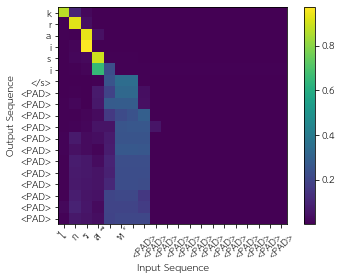

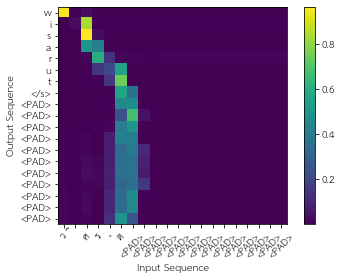

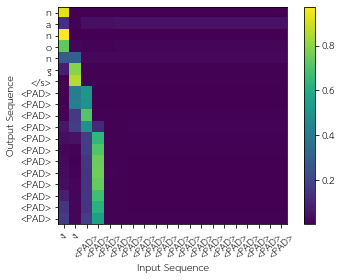

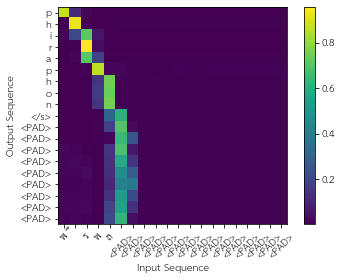

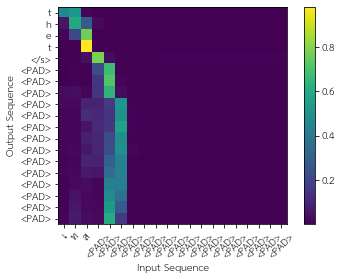

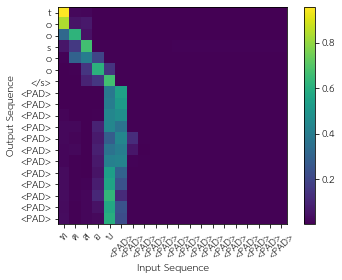

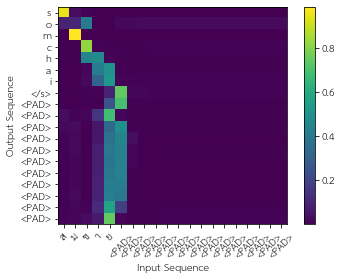

In [47]:
for i in range(len(EXAMPLES)):
  plot_attention_map(EXAMPLES, prediction, i)